# 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1E-vTKoRQdfaM-gJ1ejZEYjDrQK6K2Mmu/Progetto AN2DL


# ⚙️ Import Libraries

In [2]:
%env PYTHONHASHSEED=random
!pip install keras-cv # Install the missing module

env: PYTHONHASHSEED=random
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 50.6 MB/s eta 0:00:00


In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import keras.src.engine
#import tensorflow_addons as tfa
#from torch_optimizer import Ranger


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [4]:
import keras_cv.layers

In [ ]:
#import tensorflow_addons as tfa

# ⌛ Load Already Processed Data

In [5]:
# Load the new balanced training data
data = np.load('data_filtered.npz')
X = data['images']
y = data['labels']


In [6]:
# Divide training and validation set from the filtered dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed,
                                                                       test_size=0.10, stratify=np.argmax(y,axis=1))

In [7]:
# Show the dimensions of the different datasets
print(f"\nDimension of Training balanced set X: {X_train.shape}")
print(f"Dimension of Training balanced set y: {y_train.shape}")

print(f"\nDimension of Testing set X: {X_val.shape}")
print(f"Dimension of Testing set y: {y_val.shape}")


Dimension of Training balanced set X: (10748, 96, 96, 3)
Dimension of Training balanced set y: (10748, 1)

Dimension of Testing set X: (1195, 96, 96, 3)
Dimension of Testing set y: (1195, 1)


# 🔝 Data Augmentation (no balancing)

In [8]:
#Apply Random Augmentation on the training set
rand_augmentation = keras_cv.layers.RandAugment(
    value_range=[0, 255],
    augmentations_per_image=1,
    magnitude=0.5,
    magnitude_stddev=0.15,
    rate=0.90,
    geometric=True,
    seed=seed
)

X_train = rand_augmentation(X_train)

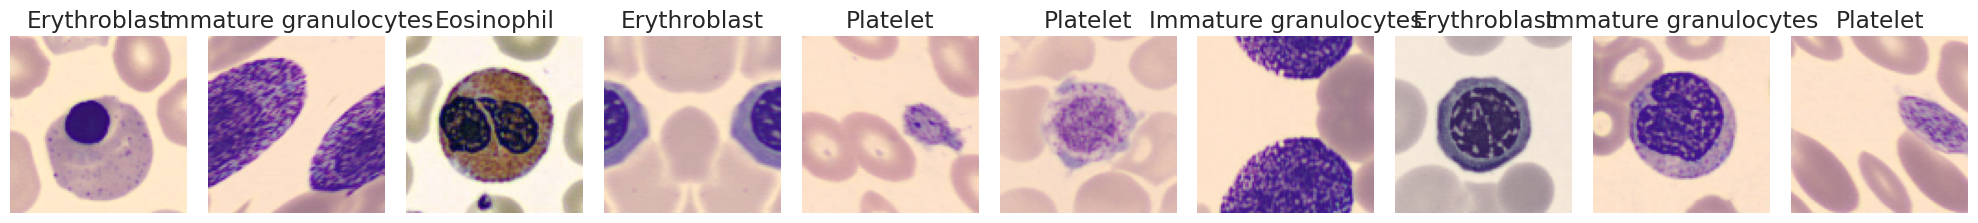

In [9]:
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train[idx]/255), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y_train[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Normalize data to the range [0, 1]
#X_train = (X_train / 255).astype('float32')
#X_val = (X_val / 255).astype('float32')

In [10]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [11]:
# Show the dimensions of the different datasets
print(f"\nDimension of Training balanced set X: {X_train.shape}")
print(f"Dimension of Training balanced set y: {y_train.shape}")

print(f"\nDimension of Testing set X: {X_val.shape}")
print(f"Dimension of Testing set y: {y_val.shape}")


Dimension of Training balanced set X: (10748, 96, 96, 3)
Dimension of Training balanced set y: (10748, 8)

Dimension of Testing set X: (1195, 96, 96, 3)
Dimension of Testing set y: (1195, 8)


# 🧮 Define Network Parameters

In [12]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [13]:
# Parameters for the Convolutational and Dense Blocks
stack = 1

units1=256
units2=units1

filters_in = 32
filters = 64
kernel_size = 3

In [14]:
# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.0001

# Print the defined parameters
#print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Batch Size: 128
Learning Rare: 0.0001


# 🏗 Assembling the model

In [19]:
# Initialise EfficientNetB0 model with ImageNet pretrained weights
pretrained_net = tfk.applications.EfficientNetB0 (
    input_shape=input_shape,
    include_top=False,
    weights = 'imagenet',
    pooling='avg'
    #classes=output_shape,
    #classifier_activation='softmax'
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
#Build our Final Model: we added just a dropout layer and the output layer
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    aug=False,
    dropout_rate_conv=0,
    dropout_rate_dense=0.3,
    l2_lambda=5e-4,
    seed=seed,
    activation='relu',
    trainable_all=False,
    trainable_CONV2D=True,
    trainable_DCONV2D=False,
    non_trainable_layers=30
):
    tf.random.set_seed(seed)

    # Regulizer and Initializer
    regularizer = tf.keras.regularizers.l2(l2_lambda)
    initializer = tf.keras.initializers.GlorotNormal(seed=seed)

    # Set all pretrained_net layers as non-trainable
    pretrained_net.trainable = trainable_all
    # Enable training only for Conv2D and DepthwiseConv2D layers
    for layer in pretrained_net.layers:
        if isinstance(layer, tfkl.Conv2D) and trainable_CONV2D:
            layer.kernel_regularizer = regularizer
            layer.kernel_initializer = initializer
            layer.trainable = trainable_CONV2D
        elif isinstance(layer, tfkl.DepthwiseConv2D) and trainable_DCONV2D:
            layer.depthwise_regularizer = regularizer
            layer.depthwise_initializer = initializer
            layer.trainable = trainable_DCONV2D

    for layer in pretrained_net.layers[:non_trainable_layers]:
      layer.trainable = False

    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation
    if aug:
        x = augmentation(input_layer)
    else:
        x = input_layer

    # Add a resizing layer to adapt inputs to EfficientNet's expected size
    #x = tf.keras.layers.Resizing(96, 96, name="resize_layer")(input_layer)

    # Preprocessing layer
    #x = tf.keras.applications.efficientnet.preprocess_input(x)

    # Use the pretrained neural network (set pretrained_net externally)
    x = pretrained_net(x)



     # Add Dropout
    if dropout_rate_conv > 0:
        x = tf.keras.layers.Dropout(dropout_rate_conv, seed=seed, name='Dropout_Conv')(x)

    if dropout_rate_dense > 0:
        x = tf.keras.layers.Dropout(dropout_rate_dense, seed=seed, name='Dropout_Dense')(x)



    # Add output layer
    output_layer = tf.keras.layers.Dense(
        units=output_shape,
        activation='softmax',
        kernel_regularizer=regularizer,
        kernel_initializer=initializer,
        name='Output'
    )(x)


    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Custom')

    # Compile the model with Adam optimizer
    optimizer =Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [21]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

# 🛠️ Train and Save the Model

## 💪 Classic training

In [22]:
# Number of training epochs
epochs = 200

# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    mode='max',
    patience=patience,
    restore_best_weights=True
)
#tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=15, min_delta=1e-5)

# Store the callback in a list
callbacks = [early_stopping]

In [23]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

Epoch 1/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 95s 621ms/step - accuracy: 0.5440 - loss: 1.3128 - val_accuracy: 0.9280 - val_loss: 0.2360
Epoch 2/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8871 - loss: 0.3395 - val_accuracy: 0.9623 - val_loss: 0.1350
Epoch 3/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9248 - loss: 0.2232 - val_accuracy: 0.9640 - val_loss: 0.1214
Epoch 4/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9466 - loss: 0.1634 - val_accuracy: 0.9707 - val_loss: 0.1064
Epoch 5/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9584 - loss: 0.1231 - val_accuracy: 0.9423 - val_loss: 0.1883
Epoch 6/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9630 - loss: 0.1092 - val_accuracy: 0.9598 - val_loss: 0.1433
Epoch 7/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9784 - loss: 0.0751 - val_accuracy: 0.9632 - val_loss: 0.1236
Epoch 8/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9801 - loss: 0.0626 - val_accurac

## 💿 Save The Model

In [26]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Final_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

Final validation accuracy: 98.58%


# ✅ Model evaluation

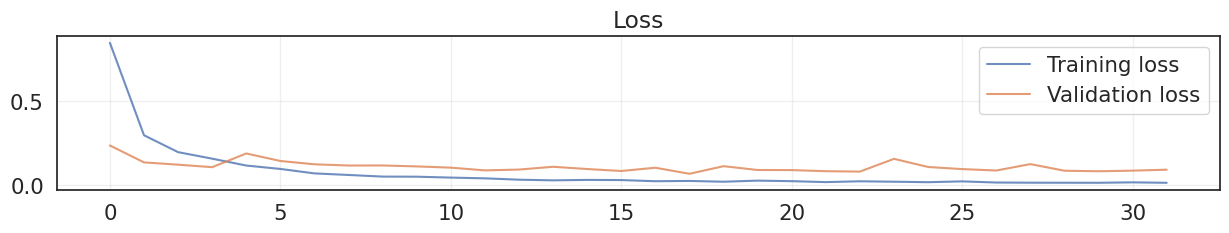

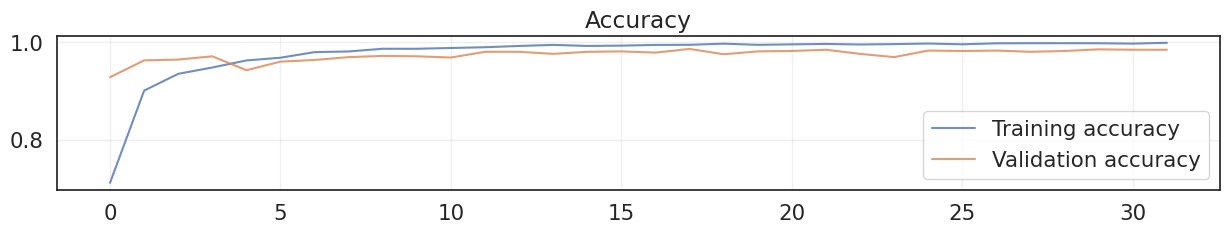

In [25]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Number of misclassified images: 24


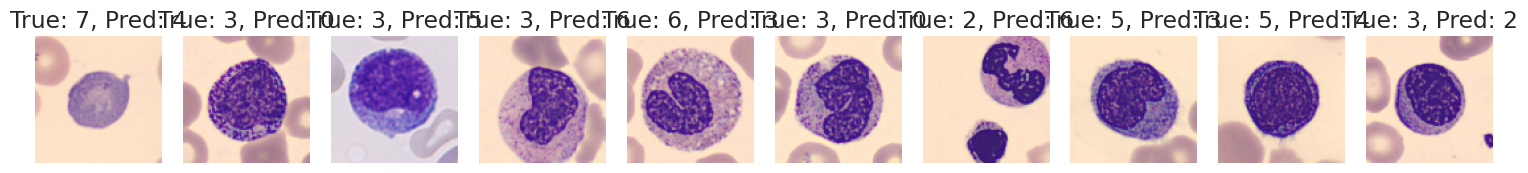

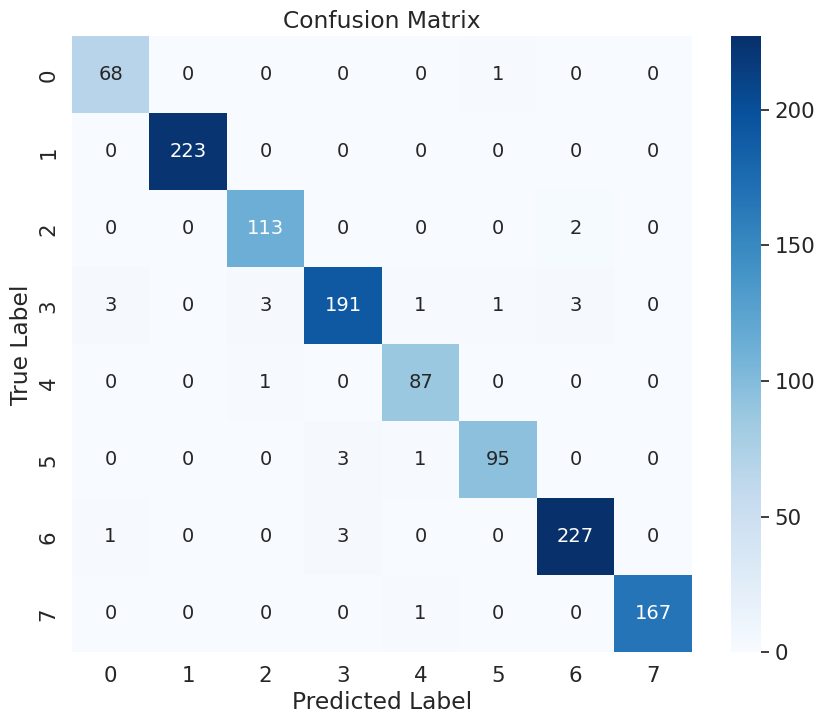

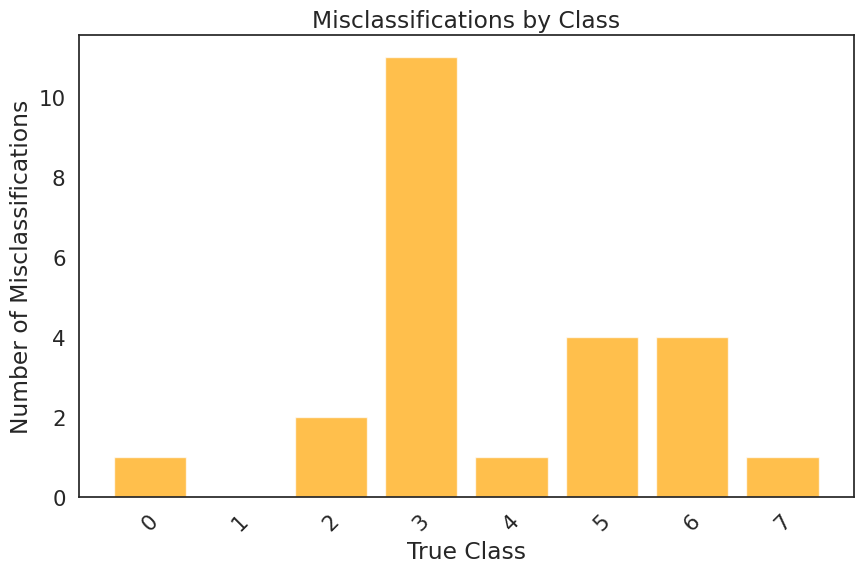

In [29]:
# Make predictions on the test/validation set
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Identify misclassified samples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

print(f"Number of misclassified images: {len(misclassified_indices)}")

# Display some misclassified images
num_images_to_show = 10  # Adjust as needed
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:num_images_to_show]):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(X_test[index].astype("uint8"))  # Convert if necessary
    plt.title(f"True: {true_classes[index]}, Pred: {predicted_classes[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

class_names={0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}
# Generate a confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display a bar chart of misclassifications
misclassified_counts = np.zeros(len(class_names))
for index in misclassified_indices:
    misclassified_counts[true_classes[index]] += 1

plt.figure(figsize=(10, 6))
plt.bar(range(len(class_names)), misclassified_counts, color='orange', alpha=0.7)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.xlabel("True Class")
plt.ylabel("Number of Misclassifications")
plt.title("Misclassifications by Class")
plt.show()